<a href="https://colab.research.google.com/github/gwijthoff/HTRC_SF_experiments/blob/main/htrc_sf_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of HTRC data

HTRC provides a number of [specialized worksets](https://analytics.hathitrust.org/staticrecommendedworksets), or topic-based collections of volumes/books digitized by HathiTrust. Here, we'll be working with David Mimno and Laure Thompson's 20th Century English-Language Speculative Fiction workset. It contains 2,454 "volumes of speculative fiction [from 1900-1999] identified both through matching titles and authors to [Worlds Without End](https://www.worldswithoutend.com/) (WWE), an extensive fan-built database of speculative fiction, and via computational text similarity analysis techniques."

The [HTRC Analytics interface](https://analytics.hathitrust.org) provides a few different, pre-defined ways of accessing that data, including:

- **Extracted Features**: a data format developed by HTRC that provides quantitative information describing every page of every volume in the collection. Each file is a compressed JSON. The files allow for nonconsumptive use of post 1923 works by providing "quantitative abstractions of a book’s written content" and metadata about each book. You need to use `rsync` to download these Extracted Features files for the entire SF workset. *I've already done so and downloaded all of the Extracted Features data into the `data/SpecFic_extracted_features` directory of this Drive folder.* But for future reference, here are the [instructions for doing so](https://analytics.hathitrust.org/algorithms/Extracted_Features_Download_Helper?wsname=20th+Century+English-Language+Speculative+Fiction%40htrc). That process generates a shell script, `EF_Rsync.sh`. Once downloaded and run, that script will download the Extracted Features files for all 2,454 of those volumes. As we'll see in a bit, those files are stored in a tricky pairtree file/folder format.
- **CSV**: Direct download of the file `20th Century English-Language Speculative Fiction-htrc.csv`, which lists major bibliographic metadata for each volume in the workset
- **Named Entity Recognition**: `entities.csv`: generated by HTRC's Named Entity Recognizer, which identifies particular tokens/words in the workset as person, organization, place
- **Token Counts**: `token_counts.csv`: raw counts of every token/word in the workset

# Working with metadata for entire SF workset

First, we'll 'mount' Google Drive in order to work with files stored there. Follow the instructions for finding and entering your authorization code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we need to figure out where the files are that you want to work with. I put a copy of all the relevant data files into a subfolder with sharing permissions. The code cell below navigates to that folder in my Google Drive, where the files also are. If you put your file somewhere other than the root of your Google Drive, you can put in the folder path (e.g. `myfolder/HTRC_SF`).

In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/HTRC_SF')

import pandas as pd

FileNotFoundError: ignored

Now, we'll read in the CSV file containing bibliographic information on the SF workset as a DataFrame.

In [5]:
#sample using Github links to pull in data
import pandas as pd

sfhtrc_csv = "https://raw.githubusercontent.com/gwijthoff/HTRC_SF_experiments/main/data/20th%20Century%20English-Language%20Speculative%20Fiction-htrc.csv"
sf_biblio = pd.read_csv(sfhtrc_csv, delimiter=",", encoding='utf-8')
sf_biblio

,id,title,year,language,authors
0,mdp.39015028685199,The Alien condition. Edited by Stephen Goldin.,1973,eng,"Goldin, Stephen"
1,mdp.39015046479799,The sea came in at midnight / Steve Erickson.,1999,eng,"Erickson, Steve"
2,mdp.39015005649820,Plague ship / by Andre Norton.,1978,eng,"Norton, Andre"
3,mdp.39015011695874,The time traders / Andre Norton.,1978,eng,"Norton, Andre"
4,mdp.39015011358150,Blue Adept / Piers Anthony ; [map by Chris Bar...,1981,eng,"Anthony, Piers"
...,...,...,...,...,...
2449,mdp.39015000146798,The wind's twelve quarters : short stories / b...,1975,eng,"Le Guin, Ursula K. 1929-"
2450,mdp.39015034647167,Doorways in the sand / Roger Zelazny.,1977,eng,"Zelazny, Roger"
2451,nyp.33433105944254,"A modern Utopia, by H. G. Wells.",1905,eng,"Wells, H. G. (Herbert George) 1866-1946; Sulli..."
2452,nnc1.cu16181638,The castle of iron :\na science fantasy adventure,1962,NaN,"De Camp, L. Sprague 1907-2000"


In [ ]:
# read the bibliographic metadata csv as a new dataframe
sf_biblio = pd.read_csv('data/20th Century English-Language Speculative Fiction-htrc.csv', delimiter=",", encoding='utf-8')
# a couple year values are NaN, convert them to 0
# sf_biblio['year'] = sf_biblio['year'].fillna(0)
# convert year floats / decimals to integers / whole numbers
sf_biblio['year'] = sf_biblio['year'].astype('int64')
# drop the language column, as everything here is in English
sf_biblio = sf_biblio.drop(columns="language")
# rename column to match other dataframes
sf_biblio = sf_biblio.rename(columns = {'id':'vol_id'})
# sample ten volumes
sf_biblio.sample(10)

,vol_id,title,year,authors
2,mdp.39015005649820,Plague ship / by Andre Norton.,1978,"Norton, Andre"
1694,mdp.39015020746072,The clan of the cave bear : a novel / Jean M. ...,1980,"Auel, Jean M"
243,mdp.39015029223008,Outside the dog museum / Jonathan Carroll.,1992,"Carroll, Jonathan 1949-"
1022,mdp.39015009018329,The lord of the spiders / Michael Moorcock.,1979,"Moorcock, Michael 1939-"
1558,pst.000013974657,The hex witch of Seldom / Nancy Springer.,1988,"Springer, Nancy"
1886,mdp.39015063093465,Giant bones / by Peter S. Beagle.,1997,"Beagle, Peter S"
104,uc1.32106015482331,Shadow's end / Sheri S. Tepper,1995,"Tepper, Sheri S"
1446,mdp.39015008821251,The illearth war / Stephen R. Donaldson.,1978,"Donaldson, Stephen R"
184,uva.x001145109,Visible light / C.J. Cherryh.,1986,"Cherryh, C. J"
1396,pst.000014404603,Starquake / Robert L. Forward.,1986,"Forward, Robert L; Forward, Robert L"


We now have a structured DataFrame that contains the HTRC volume ID, the title of the volume, its publication year, and its author.

But there are many other data fields in the Extracted Features and NER data that we'll want to work with. Let's merge this DataFrame with those other datasets.

# Get the pairtree path for all volumes

`rsync` downloads all Extracted Features files in a convoluted pairtree folder format. For example, the data file for a novel at the HTRC url <http://hdl.handle.net/2027/mdp.39015028685199> will be downloaded via rsync in the directory structure `mdp/31289/mdp.39015028685199.json.bz2`. 

We can use one of the utilities in HTRC's Feature Reader to reconstruct the pairtree paths. First, let's install Feature Reader, which we'll use later to explore the Extracted Features files.

In [ ]:
# install the HTRC Feature Reader
! pip install htrc-feature-reader

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 1.4MB 9.6MB/s 
     |████████████████████████████████| 235kB 41.1MB/s 
  Created wheel for htrc-feature-reader: filename=htrc_feature_reader-2.0.7-cp37-none-any.whl size=40428 sha256=c642c6d4d2c0ea8b63d812dab17342ed982dd8f0064755d5066fdc853ef49f06
  Stored in directory: /root/.cache/pip/wheels/44/f0/b7/3d8eac07e7e078731fd3521d5ceda301dcb88495a8f29f4a7e
  Created wheel for pymarc: filename=pymarc-4.1.1-cp37-none-any.whl size=152973 sha256=ec3f59b905265fad3390e13a8c1a4501ae4dbd3654d338570bcd059b306bcef3
  Stored in directory: /root/.cache/pip/wheels/d6/87/eb/fbd4e682e595eef5e87c9b42bfdf8763f03a14eedd5b717bb1
Successfully built htrc-feature-reader pymarc


Now, let's use the `htid2rsync` utility. From the [documentation](https://github.com/htrc/htrc-feature-reader/blob/master/examples/ID_to_Rsync_Link.ipynb):

> When you install the HTRC Feature Reader, a command line utility is installed, `htid2rsync`, which converts one or more volume ids to paths in the rsync pairtree. . . . Loading volume ids from a file: If you have a file of volume ids, one per line, use --from-file filename, or just -f filename.

In order to reconstruct the filepaths for each volume, we can use the HTRC volume IDs column in the `data/20th Century English-Language Speculative Fiction-htrc.csv` used above. I've just created a text file with a list of those HTRC IDs, one on each line: `sf_ids.txt`. [There's probably a pythonic way of doing this, but I felt lazy and just manually copy-pasted.] We'll use that .txt file to convert HTRC IDs to local pairtree paths.

So, this shell command will take each HTRC ID in `sf_ids.txt`, one volume per line, and convert them to the pairtree directory of each volume's associated Extracted Features file in a new file, `paths.txt`.

In [ ]:
! htid2rsync --f data/sf_ids.txt -o data/paths.txt

# Merging pairtree paths with bibliographic DataFrame

Now we need to create two lists from those .txt files, one for HTRC IDs and another for pairtree paths. Let's begin with the one for paths:

In [ ]:
from htrc_features import FeatureReader

#  create a list from paths.txt line by line
path_file = open('data/paths.txt')
list1 = path_file.readlines()
items = []
for i in list1:
    items.append(i)

# remove the \n character from that list
list2 = [x[:-1] for x in items]

# add home directory slugs
dir = 'data/SpecFic_extracted_features/'
paths = [dir + x for x in list2]
paths[:10] # view the first 10 items in the list

['data/SpecFic_extracted_features/mdp/31289/mdp.39015028685199.json.bz2',
 'data/SpecFic_extracted_features/mdp/31479/mdp.39015046479799.json.bz2',
 'data/SpecFic_extracted_features/mdp/31042/mdp.39015005649820.json.bz2',
 'data/SpecFic_extracted_features/mdp/31197/mdp.39015011695874.json.bz2',
 'data/SpecFic_extracted_features/mdp/31155/mdp.39015011358150.json.bz2',
 'data/SpecFic_extracted_features/uva/x019/uva.x000221509.json.bz2',
 'data/SpecFic_extracted_features/uc1/30038/uc1.32106006839184.json.bz2',
 'data/SpecFic_extracted_features/coo1/a+30226/coo1.ark+=13960=t2z32cn6s.json.bz2',
 'data/SpecFic_extracted_features/mdp/31021/mdp.39015008521117.json.bz2',
 'data/SpecFic_extracted_features/mdp/31049/mdp.39015000543895.json.bz2']

And now one for the HTRC IDs:

In [ ]:
#  create a list from sf_ids.txt line by line
id_file = open('data/sf_ids.txt')
listids = id_file.readlines()
items = []
for i in listids:
    items.append(i)

# remove the \n character from that list
ids = [x[:-1] for x in items]

ids[:5] # view the first 5 items in the list

['mdp.39015028685199',
 'mdp.39015046479799',
 'mdp.39015005649820',
 'mdp.39015011695874',
 'mdp.39015011358150']

Now let's zip those two lists together as a list of tuples, and create a DataFrame out of it.

In [ ]:
id_tuples = list(zip(ids, paths))
id_tuples[:5] 

[('mdp.39015028685199',
  'data/SpecFic_extracted_features/mdp/31289/mdp.39015028685199.json.bz2'),
 ('mdp.39015046479799',
  'data/SpecFic_extracted_features/mdp/31479/mdp.39015046479799.json.bz2'),
 ('mdp.39015005649820',
  'data/SpecFic_extracted_features/mdp/31042/mdp.39015005649820.json.bz2'),
 ('mdp.39015011695874',
  'data/SpecFic_extracted_features/mdp/31197/mdp.39015011695874.json.bz2'),
 ('mdp.39015011358150',
  'data/SpecFic_extracted_features/mdp/31155/mdp.39015011358150.json.bz2')]

Now create a new DataFrame.

In [ ]:
dfid = pd.DataFrame(id_tuples, columns = ['vol_id', 'path'])
dfid.sample(5) # random sample of 5 items from the df

,vol_id,path
837,mdp.39015008175815,data/SpecFic_extracted_features/mdp/31071/mdp....
630,pst.000017775953,data/SpecFic_extracted_features/pst/0079/pst.0...
1536,mdp.49015000704743,data/SpecFic_extracted_features/mdp/41004/mdp....
1875,mdp.39015042474877,data/SpecFic_extracted_features/mdp/31477/mdp....
1407,mdp.39015010838004,data/SpecFic_extracted_features/mdp/31130/mdp....


And finally, merge that new DataFrame with our existing `sf_biblio` DataFrame.

In [ ]:
bibloc = pd.merge(sf_biblio, dfid, on='vol_id')
bibloc.fillna('',inplace=True) # replace all NaN values
bibloc.sample(5)

,vol_id,title,year,authors,path
1963,mdp.39015005896322,Invisible cities. Translated from the Italian ...,1974,"Calvino, Italo",data/SpecFic_extracted_features/mdp/31092/mdp....
1174,mdp.39015005670925,World's end / Joan D. Vinge.,1984,"Vinge, Joan D",data/SpecFic_extracted_features/mdp/31072/mdp....
144,uc1.32106007706226,Women of wonder: science fiction stories by wo...,1975,"Sargent, Pamela",data/SpecFic_extracted_features/uc1/30002/uc1....
114,uc1.32106007176867,The conglomeroid cocktail party / Robert Silve...,1984,"Silverberg, Robert",data/SpecFic_extracted_features/uc1/30076/uc1....
781,pst.000029273768,Ringworld : a novel / by Larry Niven.,1970,"Niven, Larry",data/SpecFic_extracted_features/pst/0027/pst.0...


# Using our new bibliographic DF to query Extracted Features

We can now use this DataFrame containing bibliographic and file path info to query Extracted Features data on each book.

Let's filter the author column to all volumes containing the string "Delany," to find works included in this workset written by Samuel R. Delany.

In [ ]:
bibloc[bibloc['authors'].str.contains('Delany')]

,vol_id,title,year,authors,path
277,mdp.39015008955943,"Driftglass, by Samuel R. Delaney [i.e. Delany]",1971,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31054/mdp....
328,mdp.39015014574118,The bridge of lost desire / Samuel R. Delany.,1987,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31171/mdp....
378,mdp.39015005320745,Babel-17 / Samuel R. Delany ; with a new intro...,1976,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31024/mdp....
495,osu.32435058033408,The jewels of Aptor / Samuel R. Delany. The se...,1962,"Delany, Samuel R; White, James",data/SpecFic_extracted_features/osu/33530/osu....
646,mdp.39015008420773,The fall of the towers / Samuel R. Delany ; wi...,1977,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31027/mdp....
670,uc1.32106008842756,Triton / Samuel R. Delany.,1976,"Delany, Samuel R",data/SpecFic_extracted_features/uc1/30045/uc1....
765,mdp.39015008600119,Stars in my pocket like grains of sand / Samue...,1984,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31001/mdp....
804,mdp.39015046879170,Flight from Nev?r?on / Samuel R. Delany.,1985,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31477/mdp....
877,mdp.39015016440722,The ballad of Beta-2 / by Samuel R. Delany.,1965,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31142/mdp....
1217,mdp.39015012119213,Tales of Neveryon. By S. Delany.,1979,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31111/mdp....


Now we can use the DataFrame index (number in the leftmost column) to select a volume's filepath and interact with its Extracted Features data. To explore Delany's classic *Triton* (first published as *Trouble on Triton*), we'll use `iloc` to select a cell at row 670 and column 4 (counting over from the left beginning at 0).

In [ ]:
tritonPath = bibloc.iloc[670, 4]
tritonPath

'data/SpecFic_extracted_features/uc1/30045/uc1.32106008842756.json.bz2'

Now that we have that local pairtree path, we can access the Extracted Features data for that volume using HTRC's Feature Reader.

In [ ]:
from htrc_features import Volume
vol = Volume(tritonPath)
vol

And we can interact with the Extracted Features in many ways. 

In [ ]:
# View various metadata fields
print(f'There are {vol.page_count}pp. in {vol.title}, which was published in {vol.pub_place} and can be identified by OCLC number {vol.oclc}.')
print(f'This copy of {vol.title} was originally digitized at {vol.source_institution}.')

There are 396pp. in Triton /, which was published in New York (State) and can be identified by OCLC number 2084794.
This copy of Triton / was originally digitized at UCSC.


In [ ]:
# View full list of possible metadata fields
vol.parser.meta.keys()

dict_keys(['id', 'metadata_schema_version', 'enumeration_chronology', 'type_of_resource', 'title', 'date_created', 'pub_date', 'language', 'access_profile', 'isbn', 'issn', 'lccn', 'oclc', 'page_count', 'feature_schema_version', 'access_rights', 'alternate_title', 'category', 'genre_ld', 'genre', 'contributor_ld', 'contributor', 'handle_url', 'source_institution_ld', 'source_institution', 'lcc', 'type', 'is_part_of', 'last_rights_update_date', 'pub_place_ld', 'pub_place', 'main_entity_of_page', 'publisher_ld', 'publisher'])

In [ ]:
# count the number of tokens / words per page
tokenspp = vol.tokens_per_page()
tokenspp.head()

page
2    39
3    17
4     1
5    16
6    87
Name: tokenCount, dtype: int64

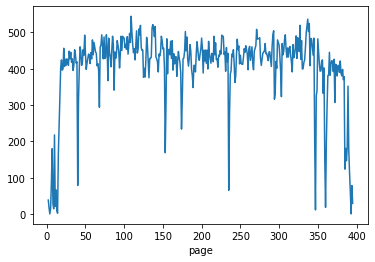

In [ ]:
# plot the count of tokens per page over the course of the book
tokenspp.plot()

In [ ]:
# return section-, part-of-speech-, and word-specific details
tl = vol.tokenlist()
tl.sample(10)

,,,,count
page,section,token,pos,
132,body,Any,DT,1
229,body,brandies,NNS,2
27,body,back,NN,1
65,body,Bellona,NNP,1
326,body,cafeteria,NN,1
275,body,Eighty-two,CD,1
310,body,Years,NNS,1
201,body,'m,VBP,1
266,body,as,RB,1


In [ ]:
# view a list of all the unique tokens / words in the book
words = vol.tokens()
# count those words / measure size of the book's vocabulary
print(len(words))

12208


In [ ]:
# view other section features
features = vol.section_features()
features[100:110]

,tokenCount,lineCount,emptyLineCount,capAlphaSeq,sentenceCount
page,,,,,
103,453,41,0,4,25.0
104,488,42,0,3,35.0
105,440,42,0,3,28.0
106,467,42,0,3,35.0
107,497,42,0,3,44.0
108,472,40,0,2,29.0
109,544,42,0,2,40.0
110,499,43,0,3,30.0
111,466,42,0,0,22.0


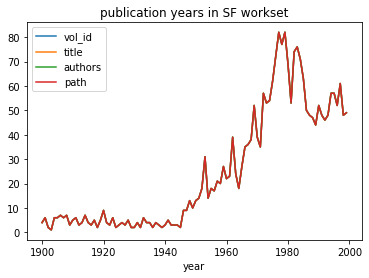

In [ ]:
# see the distribution of publication years for books in the entire SF workset
# OBVIOUSLY NOT THE WAY TO DO THIS
bibloc.groupby('year').count().plot.line(title='publication years in SF workset')

# What's next

Check out these tutorials for more examples of how to work with Extracted Features data and HTRC's Feature Reader.

- [README.ipynb](https://github.com/htrc/htrc-feature-reader/blob/master/README.ipynb) from the HTRC github documentation
- [Text Mining in Python through the HTRC Feature Reader](https://programminghistorian.org/en/lessons/text-mining-with-extracted-features) from the *Programming Historian*
- [Analyzing Documents with TF-IDF](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf) at the *Programming Historian* also uses HTRC Extracted Features
- visualize the rise and fall of topic models across a book with [htrc-book-models](https://github.com/organisciak/htrc-book-models)